In [1]:
import os, sys

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.signal import find_peaks
import seaborn as sns

In [3]:
data_dir = "../../data/2022-11-22"

In [4]:
dirnames = os.listdir(data_dir)
dirnames = list(os.path.join(data_dir, f) for f in dirnames)

fnames = []

for dirname in dirnames:
    files = os.listdir(dirname)
    for file in files:
        if ".dat" in file:
            fnames.append(f"{dirname}/{file}")
            print(file)

frq_data.dat
frq_data.dat
characterization_data.dat
frq_data.dat
characterization_data.dat
frq_data.dat
frq_data.dat
frq_data.dat


In [5]:
data = []
init_length = 300
for fname in fnames:
    dat = pd.read_csv(fname)
    dat["t"] = dat["T_(ms)"]/1000 #ms to s
    #dat["y"] = 90.08745-((dat["V_dist_(mA)"]-4)/16)*101.60 #convert milliamp to millimeters
    dat["y"] = (dat["V_dist_(mA)"]*(-100.0/16.0)+125-11.2625) #convert milliamp to millimeters
    dat["strain"] = (init_length-dat["y"])/init_length
    dat["p_c"] = (dat["Comp_P_(mA)"]-4)*0.75
    dat["v"] = dat["Sys_Volts_(V)"]
    dat["l"] = dat["LC_(grams)"]
    dat["p_p"] = (dat["Piezo_P_(mA)"]-4)*0.75
    dat["p_o"] = 6*(dat["Piezo_out_(mV)"]-4000)/16000 #converting milliamp output to expected bar output
    dat.style.set_caption(fname.split('/')[-1].split('.')[0])
    data.append(dat)

In [6]:
def plot_test(df):
    fig, axes = plt.subplots(4,1, sharex=True, figsize=(10,10))
    axes[0].plot(df["t"], df["y"],linestyle='None',marker='o',markersize=1)
    axes[0].plot(0, 0,linestyle='None',marker='o',markersize=1, color='r')
    axes[0].grid()
    axes[0].set_ylabel("Distance (mm)")
    shared_x_load = axes[0].twinx()
    shared_x_load.plot(df["t"], df["l"],linestyle='None',marker='o',markersize=1,color='r')
    shared_x_load.set_ylabel("Load (grams)")
    axes[0].legend(["Vertical Distance", "Load"],loc='upper right')
    axes[1].plot(df["t"], df["p_o"],linestyle='None',marker='o',markersize=1)
    axes[1].grid()
    axes[1].plot(df["t"], df["p_p"],linestyle='None',marker='o',markersize=1)
    axes[1].set_ylabel("Pressure - Actuator \n(Bar)")
    axes[1].set_ylim([-0.25, 6.25])
    axes[1].legend(["Pressure Out","Pressure Gauge"])
    axes[2].plot(df["t"], df["p_c"],linestyle='None',marker='o',markersize=1)
    axes[2].grid()
    axes[2].set_ylim([-0.25, 6.25])
    axes[2].set_ylabel("Pressure - Comp. \n(Bar)")

    axes[3].plot(df["t"], df["v"],linestyle='None',marker='o',markersize=1)
    axes[3].grid()
    axes[3].set_ylabel("System (V)")

    supply_frq = 2*np.pi/df['t'].iloc[find_peaks(df['p_o'])[0]].diff().mean()
    center_val = df['p_o'].mean()
    amp = abs(df['p_o'] - center_val).max()
    plt.suptitle("Experiment")

In [7]:
data[0].shape

(3649, 15)

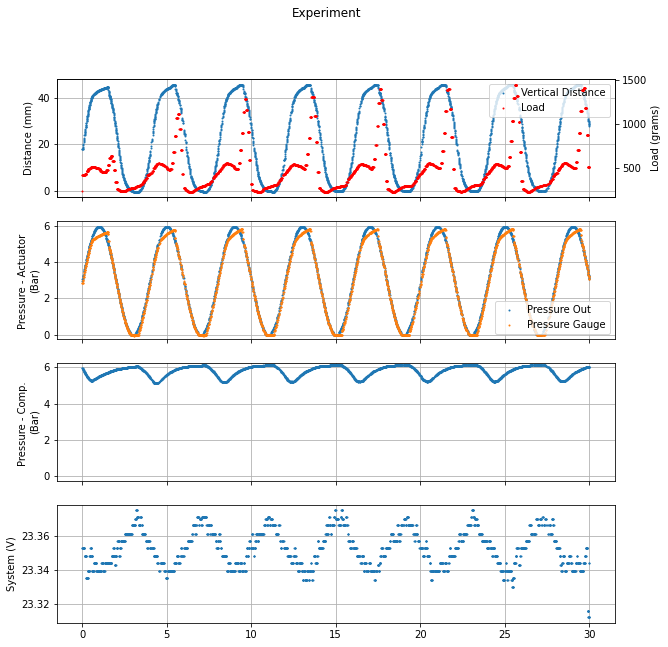

In [8]:
plot_test(data[5])

In [9]:
#bin the data to the nearest pressure
fine_char_data = data[4]
coarse_char_data = data[2]
p_bin_size = 0.5 #bar
fine_char_data['p_p_bin'] = round(fine_char_data['p_p']/p_bin_size)*p_bin_size
coarse_char_data['p_p_bin'] = round(coarse_char_data['p_p']/p_bin_size)*p_bin_size

In [22]:
#extract data for each bin of data
binned_pressure_data_fine = dict()
for pressure in fine_char_data['p_p_bin'].unique():
    if pressure < 0:
        continue
    binned_pressure_data_fine.update({f"{pressure}":fine_char_data[fine_char_data['p_p_bin'] == pressure]})

In [24]:
#for each bin, we now bin/average the data w/rt strain
strain_bin_size = 0.01
load_bin = 1 #nearest kg
result = dict()
for key in binned_pressure_data_fine.keys():
    #we now bin the nearest strain 
    binned_pressure_data_fine[key]['strain_appx'] = round(round(binned_pressure_data_fine[key]['strain']/strain_bin_size,3)*strain_bin_size,3)
    #with these binned strains, those that have the same value but variations in load will be averaged
    binned_pressure_data_fine[key]['l_bin'] = round(round(((binned_pressure_data_fine[key]['l']/1000))/load_bin)*load_bin,3)
    result.update({key:{"strain":[], "load":[]}})
    for strain_bin in binned_pressure_data_fine[key]['strain_appx'].unique():
        if strain_bin < 0.8:
            continue
        result[key]["strain"].append(1-strain_bin)
        bl_idx = (binned_pressure_data_fine[key]['strain_appx'] == strain_bin)
        mean = binned_pressure_data_fine[key].loc[bl_idx]['l_bin'].mean()
        result[key]["load"].append(mean)
        #binned_pressure_data_fine[key][bl_idx]['l_mean'] = mean
        #print(binned_pressure_data_fine[key][bl_idx]['l_mean'].unique())

/var/folders/z9/p239b1397052vtytn8xm0klc0000gq/T/ipykernel_89515/2233373312.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  binned_pressure_data_fine[key]['strain_appx'] = round(round(binned_pressure_data_fine[key]['strain']/strain_bin_size,3)*strain_bin_size,3)
/var/folders/z9/p239b1397052vtytn8xm0klc0000gq/T/ipykernel_89515/2233373312.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  binned_pressure_data_fine[key]['l_bin'] = round(round(((binned_pressure_data_fine[key]['l']/1000))/load_bin)*load_bin

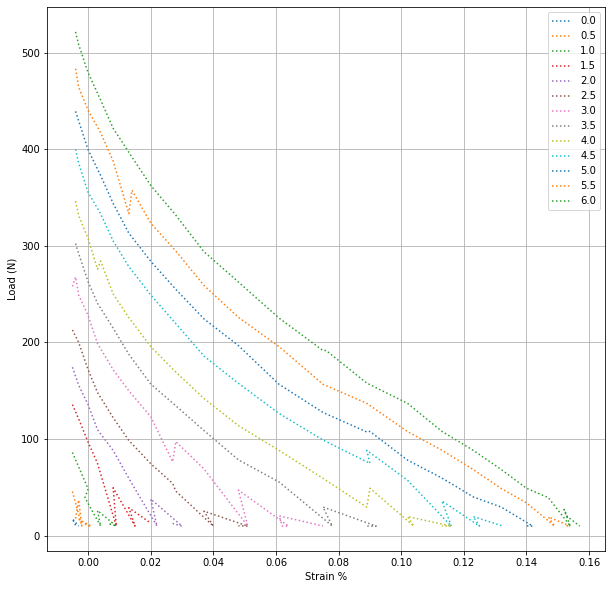

In [25]:
fig, axes = plt.subplots(figsize=(10,10))
for idx, key in enumerate(result.keys()):
    dat = np.array(result[key]['load'])*9.81
    axes.plot(np.array(result[key]['strain']), dat,linestyle=":")
axes.legend(result.keys())
axes.set_ylabel("Load (N)")
axes.set_xlabel("Strain %")
axes.grid()